# Analysis of Heart Disease Data to Predict Likelihood of Disease in an Individual.


# Introduction
Heart disease is the second most common cause of death in Canada and research shows that lifestyle modifications and medication, can significantly lower your chance of developing the disease. In this analysis, we will aim to answer the question: what factors can help us predict whether an individual will have heart disease? To answer this question, we will be using a heart disease dataset that has information on 303 patients with 14 columns containing data about different medical information. The class we want to predict is whether heart disease is present in an individual based on evaluating three predictors: cholesterol levels, blood pressure levels, and age, which are all known to affect the probability of a patient being diagnosed with heart disease.

# Exploratory Data Analysis

In [3]:
#Demonstrate that the dataset can be read from the web into R
 #read data 
library(tidyverse)
library(tidymodels)
heart_disease <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
    #rename columns
    names(heart_disease) <- c("age", "sex", "chest_pain", "blood_pressure", "cholesterol", "blood_sugar", "EKG", "heart_rate", "angina", "ST_depression", "ST_slope", "fluro", "thallium", "presence_of_disease")


In [4]:
disease_data <- heart_disease |>
    #make whether or not a patient has the disease a fct
    mutate (disease_presence = as_factor(presence_of_disease))|>
    #select the three predictors that we want to examine
    select (age, blood_pressure, cholesterol, disease_presence)
 #display the first 9 rows of the data
head(disease_data, n = 9)

,age,blood_pressure,cholesterol,disease_presence
,<dbl>,<dbl>,<dbl>,<fct>
1,67,160,286,2
2,67,120,229,1
3,37,130,250,0
4,41,130,204,0
5,56,120,236,0
6,62,140,268,3
7,57,120,354,0
8,63,130,254,2
9,53,140,203,1


We renamed the columns with names that we can understand, then selected the four columns that we are interested in examining, cholesterol levels, blood pressure levels, age and presence of heart disease.

In [5]:
#Clean and wrangle your data into a tidy format
    #make column of disease presence binary (by making all values bigger than 1 equal to 1) 
disease_data$disease_presence <-ifelse(disease_data$disease_presence=="0",0,1)
disease_data <- disease_data |>
    #make disease presence a factor again since it was transformed into a double case
    mutate (disease_presence =as_factor(disease_presence))
    head(disease_data, n = 9)   

,age,blood_pressure,cholesterol,disease_presence
,<dbl>,<dbl>,<dbl>,<fct>
1,67,160,286,1
2,67,120,229,1
3,37,130,250,0
4,41,130,204,0
5,56,120,236,0
6,62,140,268,1
7,57,120,354,0
8,63,130,254,1
9,53,140,203,1


In [6]:
    #split data into training and testing so we can use training data seperatly
disease_split <- initial_split(disease_data, prop = 0.75, strata = disease_presence)  
disease_training <- training(disease_split)   
disease_testing <- testing(disease_split)
  head(disease_training, n = 3)
  head(disease_testing, n = 3)

,age,blood_pressure,cholesterol,disease_presence
,<dbl>,<dbl>,<dbl>,<fct>
3,37,130,250,0
4,41,130,204,0
7,57,120,354,0


,age,blood_pressure,cholesterol,disease_presence
,<dbl>,<dbl>,<dbl>,<fct>
5,56,120,236,0
8,63,130,254,1
12,56,130,256,1


Having the presence of heart disease be a binary factor will allow us to better visualize the data later. 
Splitting the data is necessary because the training data is what is used to build the classifier, and the testing data is what we are trying to predict.

In [7]:
#We created a table that groups the data into individuals who present heart disease and those who don't, and allows us to see the difference between the means of the three data columns that we are intereted in. 
disease_summary <- disease_training |> 
    group_by(disease_presence)|>
    summarize(avg_age=mean(age), avg_blood_pressure=mean(blood_pressure), avg_cholesterol=mean(cholesterol))
disease_summary

disease_presence,avg_age,avg_blood_pressure,avg_cholesterol
<fct>,<dbl>,<dbl>,<dbl>
0,52.72951,129.6475,239.8361
1,56.61538,134.3942,256.5962


This summary of the data shows the mean value of our predictors of individuals with heart disease (1) and without (0), allowing us to compare the values. 


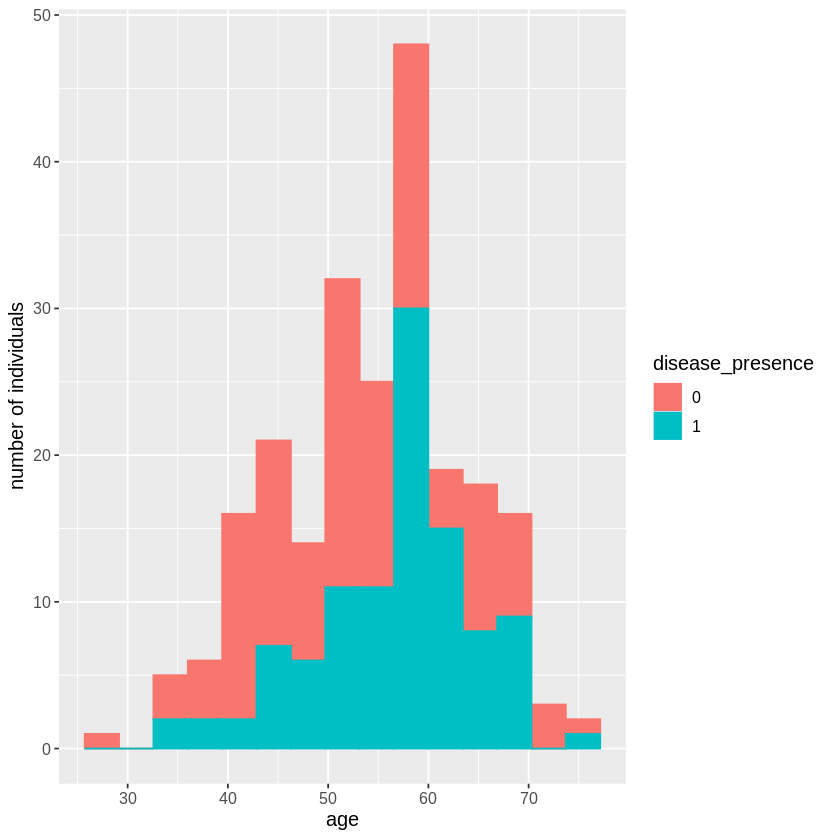

In [8]:
#An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.
disease.age_plot <- ggplot(disease_training, aes(x=age, fill=disease_presence, color=disease_presence)) +
          geom_histogram(bins=15)+
          xlab("age") +
          ylab("number of individuals") + 
          theme(text = element_text(size = 12)) 
disease.age_plot

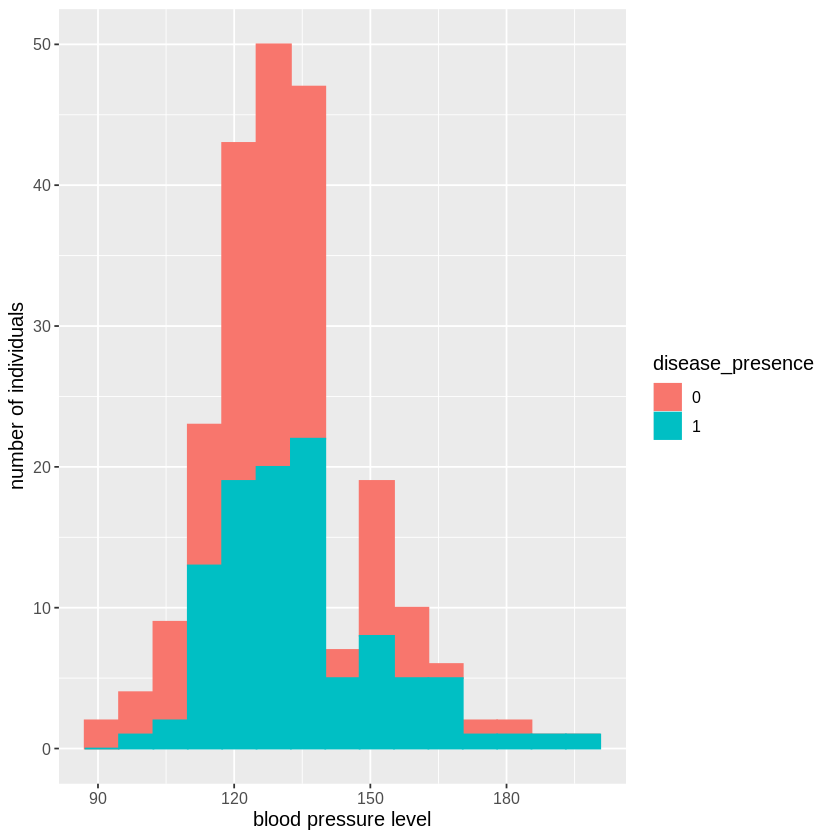

In [9]:
disease.bloodpressure_plot <- ggplot(disease_training, aes(x=blood_pressure, fill=disease_presence, color=disease_presence)) +
          geom_histogram(bins=15)+
          xlab("blood pressure level") +
          ylab("number of individuals") + 
          theme(text = element_text(size = 12)) 
disease.bloodpressure_plot

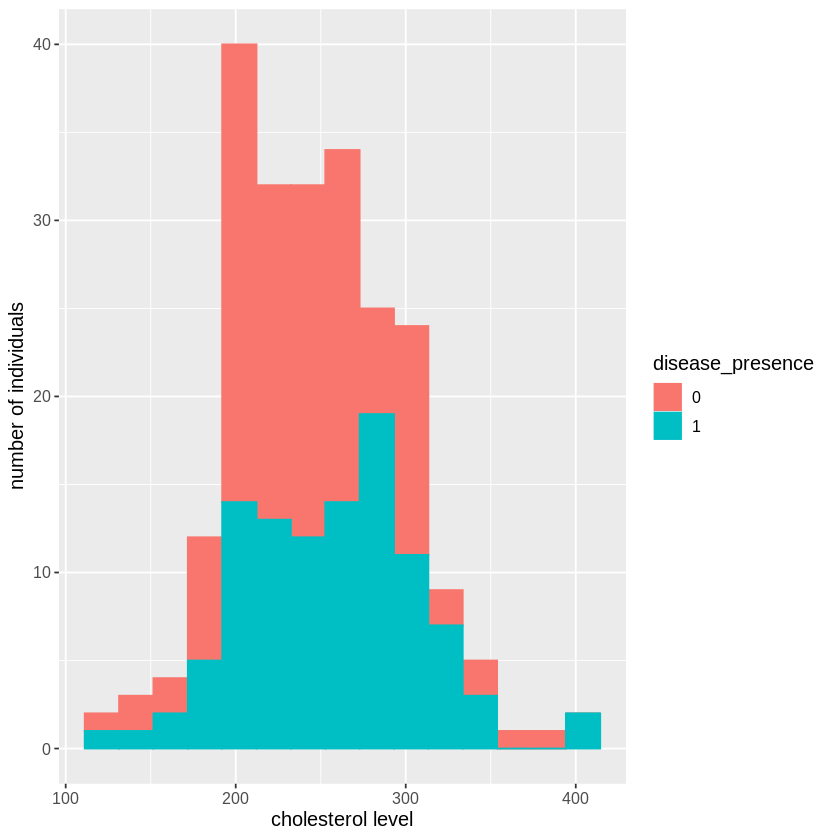

In [10]:
disease.cholesterol_plot <- ggplot(disease_training, aes(x=cholesterol, fill=disease_presence, color=disease_presence)) +
          geom_histogram(bins=15)+
          xlab("cholesterol level") +
          ylab("number of individuals") + 
          theme(text = element_text(size = 12)) 
disease.cholesterol_plot

These graphs visualize the distribution of patient data and compare the ages, cholesterol levels, and blood pressure levels of individuals with and without heart disease.

# Method
Age, cholesterol level, and blood pressure level will be our predictors because they are known factors in the development of heart disease. The older a patient is the higher the risk of heart disease becomes. The higher a patient's cholesterol or blood pressure levels, the more likely it is that their arteries or blood vessels can get damaged and clogged, which increases the risk of heart disease. 

To analyze this data we will perform classification, following these steps:
- Create a K-nearest neighbor classifier with our three predictors and check the accuracy of the K-nearest neighbor found using vfold_cv.
- Create a model using the K-nearest neighbor to predict the presence or absence of heart disease in the patient and check for accuracy again, this time using the predict function and the testing data. 
- Create a visualization of our model, using scatterplots to visualize the relationship between two predictors at a time to visualize trends in predictors and their effect on the final diagnosis for a given patient.

# Classification of Data

# Creation of Model and K-Nearest Neighbor Accurace Check
To begin the classification we will need to create a KNN model to classify the data with our three predictors. The first step in doing this is to determine the k value that will give us the most accurate predictions. Using our training data we will start by creating a tuning model and a recipe.

In [ ]:
set.seed(2000)
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_recipe <- recipe(disease_presence~age+blood_pressure+cholesterol, data = disease_training) |>
    step_scale(all_predictors())|>
    step_center(all_predictors())

# Discusion of Results

# Conclusion: Final Outcome and Significance of Results

Sources: https://memorialhermann.org/services/specialties/heart-and-vascular/healthy-living/education/heart-disease-and-age , https://familyheart.org/cholesterol-is-key , https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html